In [122]:
# Libraries
from datetime import date
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import pickle
from scipy import stats
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from dotenv import load_dotenv
from supabase import create_client
import os

In [123]:
# Read data
load_dotenv()

SUPABASE_URL = os.getenv("NEXT_PUBLIC_SUPABASE_URL")
SUPABASE_SERVICE_KEY = os.getenv("NEXT_PUBLIC_SUPABASE_SERVICE_KEY")

supabase = create_client(SUPABASE_URL, SUPABASE_SERVICE_KEY)

MAKE = "BMW"
min_observations = 10

response = (
    supabase.table("bat_completed_auctions")
    .select("year, model, mileage, normalized_color, transmission, sold_price, bid_amount, end_date, status")
    .eq("make", MAKE)
    .eq("country_code", "US")
    .not_.is_("model", None)
    .not_.is_("mileage", None)
    .not_.is_("transmission", None)
    .not_.is_("normalized_color", None)
    .not_.is_("year", None)
    .execute()
)
df = pd.DataFrame(response.data)

In [3]:
# Count by model
counts = df[['model','status']].groupby('model').count().sort_values(by='status',ascending=False)
print(counts)

                                        status
model                                         
Land Cruiser FJ40                          807
Land Cruiser FZJ80                         317
Land Cruiser FJ62                          315
Land Cruiser FJ60                          278
Land Cruiser UZJ100                        258
...                                        ...
Land Cruiser FJ60 5-Speed 4×4                1
Land Cruiser FJ60 5-Speed for Charity        1
Land Cruiser FJ60 Turbo Diesel 5-Speed       1
Land Cruiser FJ60 Turbodiesel                1
Xtracab SR5 V6 4×4 5-Speed                   1

[1405 rows x 1 columns]


In [4]:
# Price by model
display_p=df[['model','year','sold_price']]

fig=px.box(display_p,x="model",y="sold_price")
fig.update_layout(title_text='Price vs Model',xaxis_title="Model",yaxis_title="Average Price")

In [124]:
# Filter to models with more than min_observations
counts=df['model'].value_counts()
frequent_models = counts[counts >= min_observations].index

# Filter the data to frequent models
df = df[df['model'].isin(frequent_models)]
popular_labels=frequent_models

colors=['lightslategray',]*len(popular_labels)
colors[0]='crimson'

fig=go.Figure(data=[go.Bar(x=counts[:25],y=popular_labels,marker_color=colors,orientation='h')])
fig.update_layout(title_text='Most represented Models in the Dataset',xaxis_title="Count",yaxis_title="Model")

In [6]:
#distribution of number of cars over the years
dic = {1970+i : sum(df['year']==1970+i) for i in range(55)}
x_dic = [1970 + i for i in range(55)]
y_dic = [dic[1970 + i] for i in range(55)]

# Plot
fig = go.Figure([go.Bar(x=x_dic, y=y_dic)])

fig.update_layout(title="Car year distribution",
                  xaxis_title="Year",
                  yaxis_title="Count Cars sold")


fig.show()

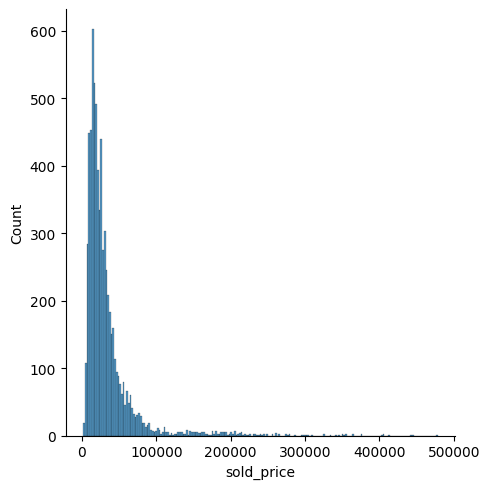

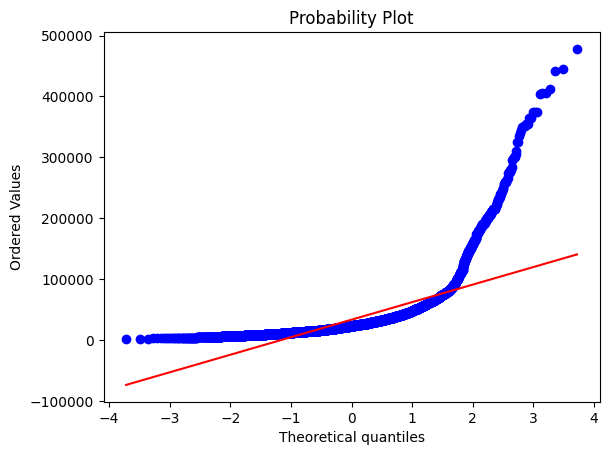

In [125]:
# Replace sold_price with bid_amount and remove outliers
df['sold_price'] = df['sold_price'].fillna(df['bid_amount'])
df = df.dropna()

# Remove outliers
price_threshold = 1000000
df.drop(df[df['sold_price'] >= price_threshold].index,inplace=True)

# Plot distribution of sold_price
sns.displot(df['sold_price'])
fig = plt.figure()
res = stats.probplot(df['sold_price'], plot=plt)


array([[<Axes: title={'center': 'year'}>,
        <Axes: title={'center': 'mileage'}>],
       [<Axes: title={'center': 'sold_price'}>,
        <Axes: title={'center': 'bid_amount'}>]], dtype=object)

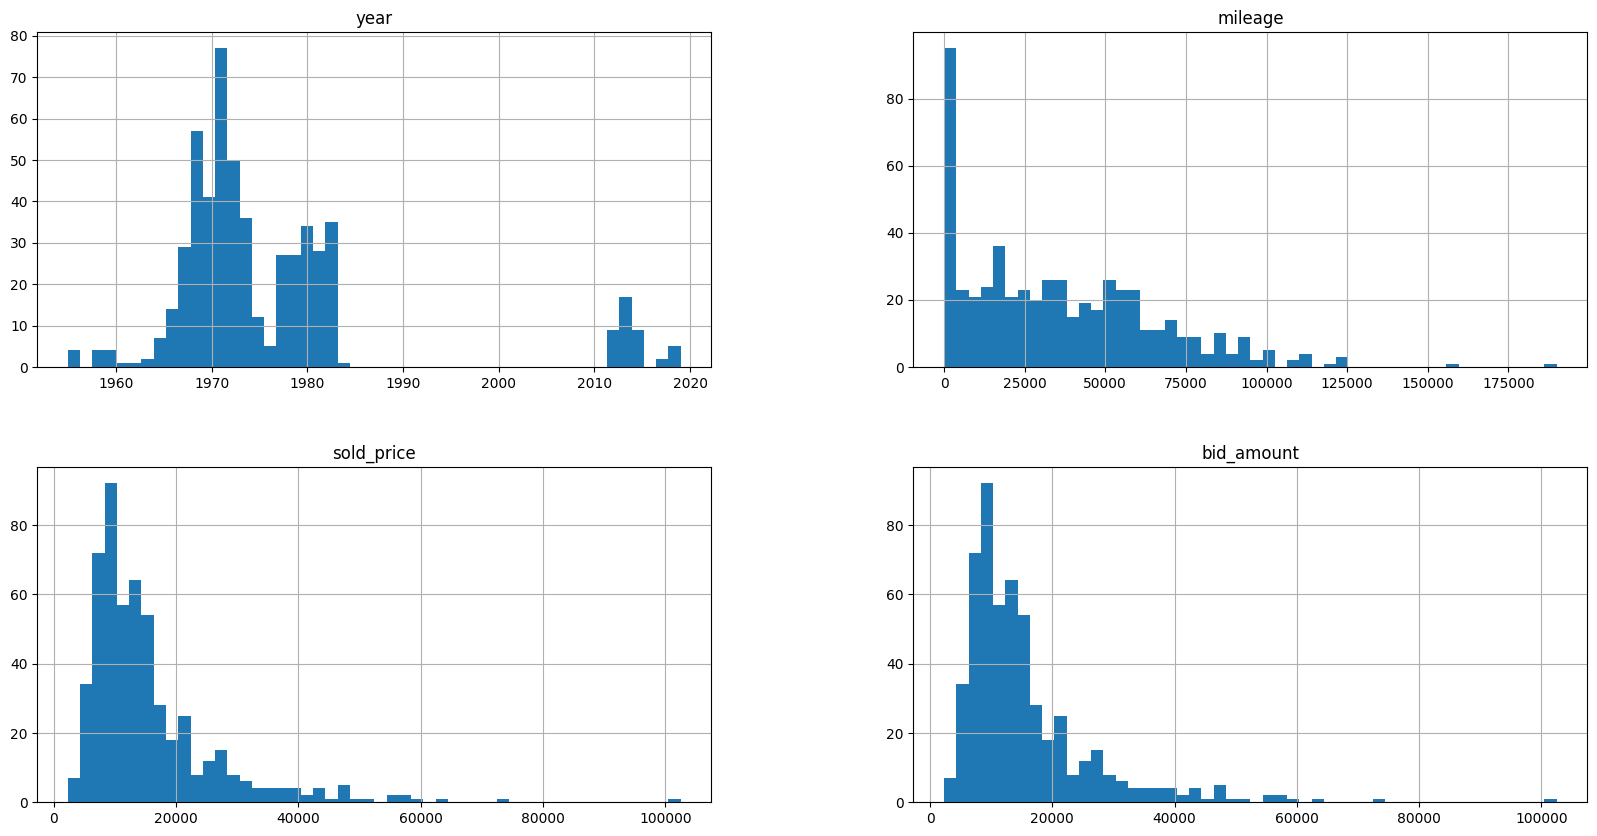

In [104]:
# Data distribution
df.hist(figsize=(20,10),bins = 50)

In [126]:
# Weight by recency
df['days_since_end'] = (pd.to_datetime(date.today()) - pd.to_datetime(df["end_date"])).dt.days
K = 1
T = 360
df['W'] = K*np.exp(-df['days_since_end']/T)


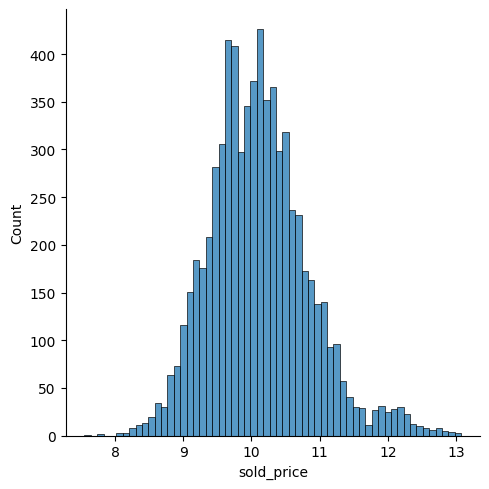

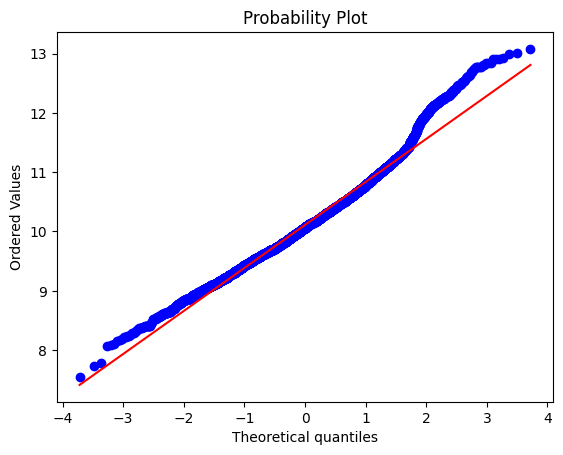

In [127]:
#Log transform sold_price & mileage
df['sold_price'] = np.log(df['sold_price'])
df['mileage'] = np.log1p(df['mileage'])

sns.displot(df['sold_price'])
fig = plt.figure()
res = stats.probplot(df['sold_price'], plot=plt)

In [86]:
# Summarize transformed data
df.describe()

,year,mileage,sold_price,bid_amount,days_since_end,W
count,1452.000000,1452.000000,1452.000000,1452.000000,1452.000000,1452.000000
mean,2007.198347,10.622061,10.393368,47220.131543,950.842975,0.229416
std,7.304015,1.118653,0.857950,42765.339821,725.530883,0.264815
min,1981.000000,2.995732,8.517193,5000.000000,2.000000,0.000091
25%,2003.000000,10.043293,9.739789,16980.000000,357.000000,0.023980
50%,2008.000000,10.896758,10.308953,30000.000000,783.000000,0.113608
75%,2012.000000,11.410338,11.130103,68194.250000,1343.000000,0.370958
max,2024.000000,12.563751,12.367341,235000.000000,3351.000000,0.994460


In [128]:
# Prepare target and features
y = df["sold_price"]
X = df.drop(["sold_price","bid_amount","end_date", "status", "days_since_end"],axis=1)
X

,year,model,mileage,normalized_color,transmission,W
2,2001,Z8,9.798183,Silver,manual,0.473681
3,2004,M3 Coupe 6-Speed,10.275086,Blue,manual,0.421520
4,2001,M5,11.429555,Silver,manual,0.383532
5,2006,X5 4.8is,11.156265,Black,automatic,0.202458
6,2004,M3 Coupe 6-Speed,10.968216,Blue,manual,0.371990
...,...,...,...,...,...,...
9630,2013,328i Convertible,10.645449,Red,automatic,0.980743
9631,1976,2002 5-Speed,10.463132,Red,manual,0.980743
9634,2002,330i Sedan,10.714440,Blue,automatic,0.978023
9636,2008,335i Convertible 6-Speed,11.225257,Bronze,manual,0.978023


In [129]:
# Encode categorical features
Lbl_model = LabelEncoder()
Lbl_color = LabelEncoder()
Lbl_trans = LabelEncoder()

#df.make=Lbl.fit_transform(df.make)
X.model=Lbl_model.fit_transform(df.model)
print("Model Mapping:", dict(zip(Lbl_model.classes_, Lbl_model.transform(Lbl_model.classes_))))
X.normalized_color=Lbl_color.fit_transform(df.normalized_color)
print("Color Mapping:", dict(zip(Lbl_color.classes_, Lbl_color.transform(Lbl_color.classes_))))
X.transmission =Lbl_trans.fit_transform(df.transmission)
print("Trans Mapping:", dict(zip(Lbl_trans.classes_, Lbl_trans.transform(Lbl_trans.classes_))))
X

Model Mapping: {'135i Sport Coupe 6-Speed': 0, '1600-2': 1, '1M': 2, '2002': 3, '2002 4-Speed': 4, '2002 5-Speed': 5, '2002tii': 6, '2002tii 5-Speed': 7, '2800CS 5-Speed': 8, '3.0CS': 9, '3.0CS 4-Speed': 10, '3.0CS 5-Speed': 11, '3.0CSi': 12, '3.0CSi 4-Speed': 13, '3.0CSi 5-Speed': 14, '316i Touring Design Edition 5-Speed': 15, '318i Convertible 5-Speed': 16, '318i Touring 5-Speed': 17, '318is 5-Speed': 18, '318ti 5-Speed': 19, '320i 4-Speed': 20, '320i 5-Speed': 21, '320iS 5-Speed': 22, '325Ci Convertible': 23, '325Ci Convertible 5-Speed': 24, '325Ci Coupe': 25, '325es 5-Speed': 26, '325i': 27, '325i 5-Speed': 28, '325i Convertible': 29, '325i Convertible 5-Speed': 30, '325i Coupe': 31, '325i Coupe 5-Speed': 32, '325i Sedan': 33, '325i Sedan 5-Speed': 34, '325i Sport Wagon': 35, '325i Sport Wagon 5-Speed': 36, '325iX Coupe 5-Speed': 37, '325is': 38, '325is 5-Speed': 39, '325xi Sport Wagon': 40, '328d xDrive Sports Wagon': 41, '328i Convertible': 42, '328i Sedan': 43, '328i Sedan 6-Spe

,year,model,mileage,normalized_color,transmission,W
2,2001,189,9.798183,15,1,0.473681
3,2004,130,10.275086,2,1,0.421520
4,2001,141,11.429555,15,1,0.383532
5,2006,163,11.156265,1,0,0.202458
6,2004,130,10.968216,2,1,0.371990
...,...,...,...,...,...,...
9630,2013,42,10.645449,14,0,0.980743
9631,1976,5,10.463132,14,1,0.980743
9634,2002,58,10.714440,2,0,0.978023
9636,2008,63,11.225257,3,1,0.978023


In [121]:
# Fit Model
# Features
# year	model	mileage	normalized_color	transmission

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = True)
param_grid = { 
    'n_estimators': [100, 200, 300],
    'criterion' :['squared_error', 'friedman_mse']
}
car_model_rf = RandomForestRegressor(random_state=33, monotonic_cst = [0,0,-1,0,0,0])
CV_rfc = GridSearchCV(estimator=car_model_rf, param_grid=param_grid, cv=5)
CV_rfc.fit(X, y, sample_weight=X['W'])
print('Random Forest Regressor Train Score is : ' ,  CV_rfc.score(X, y))
CV_rfc.best_params_

Random Forest Regressor Train Score is :  0.5687226085090009


{'criterion': 'friedman_mse', 'n_estimators': 200}

In [130]:
# Fit Model
# Features
# year	model	mileage	normalized_color	transmission

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle = True)
car_model_rf = RandomForestRegressor(n_estimators=200, random_state=33,
                                     criterion='friedman_mse', monotonic_cst = [0,0,-1,0,0,0])
car_model_rf.fit(X, y, sample_weight=X['W'])
print('Random Forest Regressor Train Score is : ' ,  car_model_rf.score(X, y))
print('Random Forest Regressor Test Score is : ' , car_model_rf.score(X_test, y_test)) 
predicted_rf = pd.DataFrame(car_model_rf.predict(X), index=X.index, columns=['predicted_rf'])
car_model_rf.feature_importances_


Random Forest Regressor Train Score is :  0.8462490763093373
Random Forest Regressor Test Score is :  0.8432730364338776


array([0.11824807, 0.60863607, 0.13187392, 0.03138558, 0.02613072,
       0.08372564])

In [ ]:
# Save model and encoders
path = f"../models/{MAKE}"
if not os.path.exists(path):
    os.makedirs(path)

pickle.dump(car_model_rf, open(f'{path}/model.pkl','wb'))
pickle.dump(Lbl_model, open(f'{path}/labels_model.pkl','wb'))
pickle.dump(Lbl_color, open(f'{path}/labels_color.pkl','wb'))
pickle.dump(Lbl_trans, open(f'{path}/labels_transmission.pkl','wb'))

In [55]:
# Inverse transform features
X_analysis = X.copy()
X_analysis.model = Lbl_model.inverse_transform(X.model)
X_analysis.normalized_color = Lbl_color.inverse_transform(X.normalized_color)
X_analysis.transmission = Lbl_trans.inverse_transform(X.transmission)
X_analysis

,year,model,mileage,normalized_color,transmission,W
1,1991,Land Cruiser FJ80,12.301387,Black,automatic,0.412256
3,2021,Land Cruiser URJ200 Heritage Edition,8.853808,Black,automatic,0.234570
5,1970,Land Cruiser FJ40,6.478510,Silver,manual,0.002041
6,1987,Land Cruiser FJ60,12.149508,White,manual,0.025919
7,2004,Land Cruiser UZJ100,11.678448,Black,automatic,0.021103
...,...,...,...,...,...,...
7583,1981,Land Cruiser FJ45 Pickup,11.759793,Beige,manual,0.978023
7585,1986,Celica Supra 5-Speed,8.853808,Red,manual,0.978023
7586,2002,4Runner SR5 4WD,11.925042,Silver,automatic,0.978023
7587,1985,Land Cruiser FJ60,12.332710,Beige,manual,0.978023


In [56]:
# Analyze Results: Add target and predicted values
X_analysis = pd.merge(y, X_analysis, how='inner', left_index=True, right_index=True)
X_analysis = pd.merge(X_analysis, predicted_rf, how='inner', left_index=True, right_index=True)
X_analysis.sold_price = np.exp(X_analysis.sold_price)
X_analysis.predicted_rf = np.exp(X_analysis.predicted_rf)
X_analysis.mileage = np.exp(X_analysis.mileage) - 1
X_analysis

,sold_price,year,model,mileage,normalized_color,transmission,W,predicted_rf
1,35000.0,1991,Land Cruiser FJ80,220000.0,Black,automatic,0.412256,20880.373144
3,101000.0,2021,Land Cruiser URJ200 Heritage Edition,7000.0,Black,automatic,0.234570,97142.811609
5,26000.0,1970,Land Cruiser FJ40,650.0,Silver,manual,0.002041,31418.881284
6,44000.0,1987,Land Cruiser FJ60,189000.0,White,manual,0.025919,23371.007886
7,40000.0,2004,Land Cruiser UZJ100,118000.0,Black,automatic,0.021103,25618.407473
...,...,...,...,...,...,...,...,...
7583,16250.0,1981,Land Cruiser FJ45 Pickup,128000.0,Beige,manual,0.978023,20480.125990
7585,13500.0,1986,Celica Supra 5-Speed,7000.0,Red,manual,0.978023,24008.232376
7586,16000.0,2002,4Runner SR5 4WD,151000.0,Silver,automatic,0.978023,16224.445090
7587,46000.0,1985,Land Cruiser FJ60,227000.0,Beige,manual,0.978023,24578.814335


In [18]:
# Define price ranges
def getrange(Price):
    if (Price >= 0 and Price < 50000):
        return '0 - 50000'
    if (Price >= 50000 and Price < 100000):
        return '50000 - 100000'
    if (Price >= 100000 and Price < 150000):
        return '100000 - 150000'
    if (Price >= 150000 and Price < 200000):
        return '150000 - 200000'
    if (Price >= 200000 and Price < 250000):
        return '200000 - 250000'
    if (Price >= 250000 and Price < 300000):
        return '250000 - 300000'
    if (Price >= 300000 and Price < 350000):
        return '300000 - 350000'
    if (Price >= 350000):
        return 'Over 350000'
X_analysis['Price Range'] = X_analysis['sold_price'].apply(lambda x:getrange(x))

X_analysis['Price Range'].value_counts()

Price Range
0 - 50000          4432
50000 - 100000      461
100000 - 150000      77
150000 - 200000      11
200000 - 250000       4
Name: count, dtype: int64

<Axes: xlabel='sold_price', ylabel='predicted_rf'>

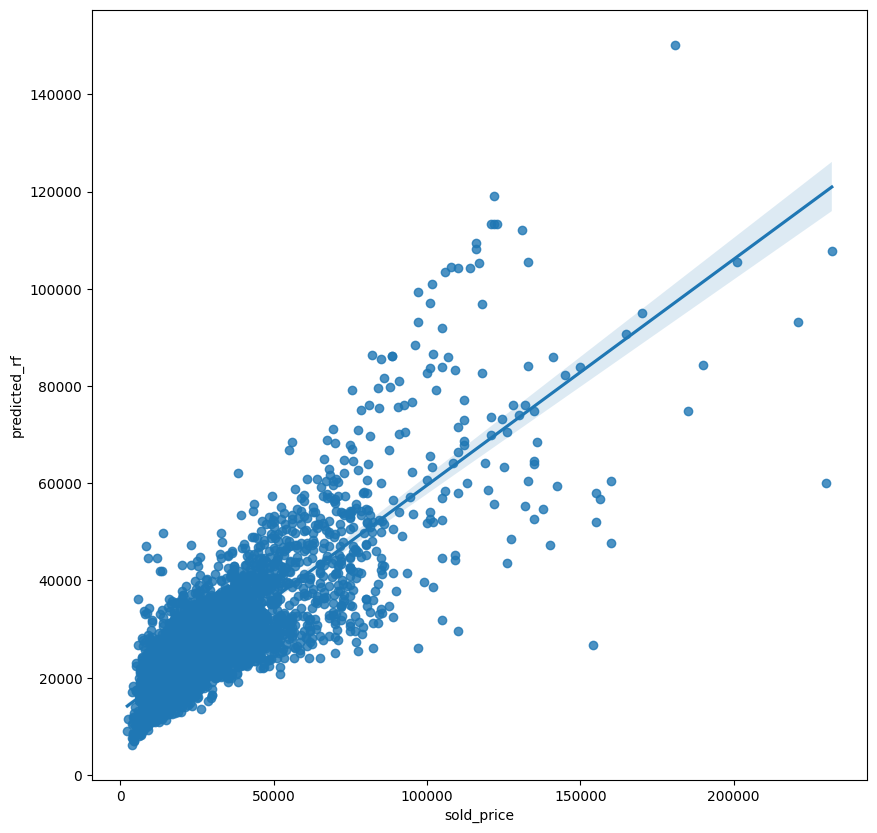

In [57]:
# Plot true vs predicted values scatter

plt.figure(figsize = (10, 10))
sns.regplot(x=X_analysis.sold_price, y=X_analysis.predicted_rf)
#sns.regplot(x=X_analysis.sold_price, y=X_analysis.predicted_xgb)

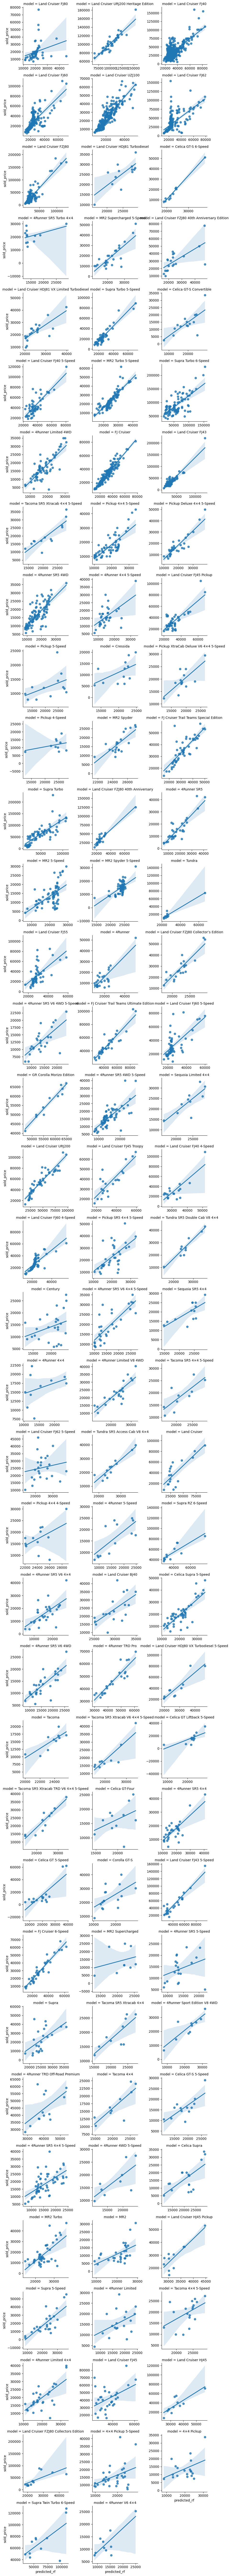

In [20]:
# Predicted vs Sold Price Scatter by model
g = sns.FacetGrid(X_analysis, col="model", col_wrap=3, sharex=False, sharey=False)

# Map scatter plots to the grid
g.map(sns.regplot, "predicted_rf", "sold_price")

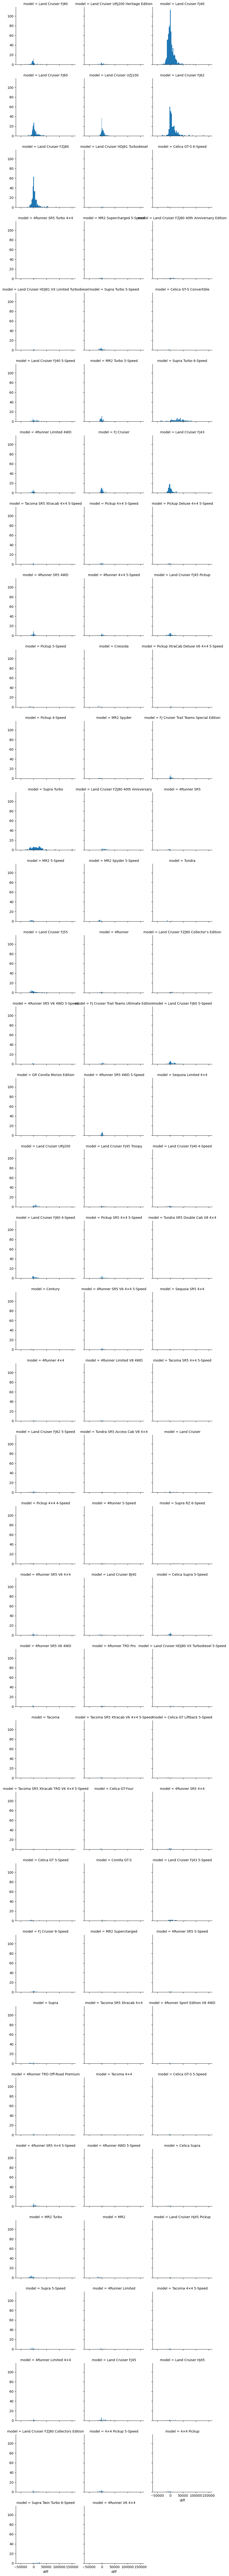

In [21]:
# Analyze Residuals by model
X_analysis['diff'] = X_analysis.sold_price - X_analysis.predicted_rf
g = sns.FacetGrid(X_analysis, col="model", col_wrap=3)

# Map scatter plots to the grid
g.map(plt.hist, "diff", bins = 50)


In [22]:
# Prediction function

def predict(year, model, mileage, color, transmission, carmodel, W):
    input_data = pd.DataFrame([[year, model, mileage, color, transmission, W]], 
                              columns=["year", "model", "mileage", "normalized_color", "transmission", "W"])
    input_data.model=Lbl_model.transform(input_data.model)
    input_data.normalized_color=Lbl_color.transform(input_data.normalized_color)
    input_data.transmission=Lbl_trans.transform(input_data.transmission)
    input_data.mileage = np.log1p(input_data.mileage)
    price_scaled = carmodel.predict(input_data)

    price = np.exp(price_scaled)
    
    return price[0].round(0)

In [23]:
# Run a prediction for a car over a range of mileage
mileage_range = np.linspace(0, 50000, 100)

predictions = []
for mileage in mileage_range:
    prediction = predict(
        year = 1992,
        model = "512 TR",
        mileage = mileage,
        color = "Black",
        transmission = "manual",
        carmodel = car_model_rf,
        W = 1
    )
    predictions.append(prediction)

predictions = pd.DataFrame(predictions, columns=["predicted"])
mileage_range = pd.DataFrame(mileage_range, columns=["mileage"])
predictions = pd.merge(predictions, mileage_range, how='inner', left_index=True, right_index=True)
plt.scatter(predictions["mileage"], predictions["predicted"])

ValueError: y contains previously unseen labels: '512 TR'